# Distributing a Parcels experiment to a cluster

After some cleanup, we'll reproduce the initial parts of the Parcels tutorial.  Sole change is that we use a few more particles that are randomly distributed across the two eddies.



In [1]:
!rm -fv output_data/*EddyParticles.nc

removed 'output_data/EddyParticles.nc'
removed 'output_data/dask_0000_EddyParticles.nc'
removed 'output_data/dask_0001_EddyParticles.nc'
removed 'output_data/dask_0002_EddyParticles.nc'
removed 'output_data/dask_0003_EddyParticles.nc'
removed 'output_data/serial_0000_EddyParticles.nc'
removed 'output_data/serial_0001_EddyParticles.nc'
removed 'output_data/serial_0002_EddyParticles.nc'
removed 'output_data/serial_0003_EddyParticles.nc'
removed 'output_data/wrapped_EddyParticles.nc'


In [2]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [3]:
fieldset = FieldSet.from_parcels("input_data/moving_eddies")

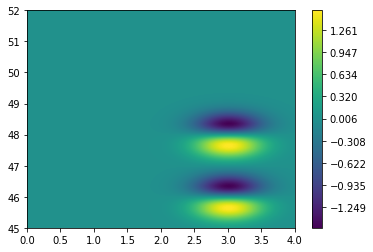

In [4]:
fieldset.U.show(animation=False)

In [5]:
N = 200
lons = 2.0 + 1.5 * np.random.rand(N)
lats = 45.5 + 3.0 * np.random.rand(N)

In [6]:
pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=JITParticle,
                             lon=lons,
                             lat=lats)

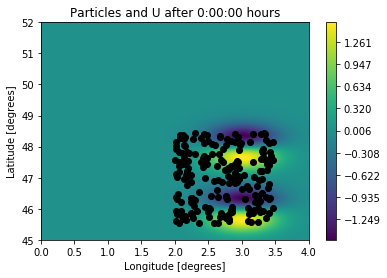

In [7]:
pset.show(field=fieldset.U)

In [8]:
%%time
pset.execute(AdvectionRK4,
             runtime=timedelta(days=5),
             dt=timedelta(minutes=5),
             output_file=pset.ParticleFile(
                 name="output_data/EddyParticles.nc",
                 outputdt=timedelta(hours=1)))

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/5bed0f51074a86dbfb362e56d893bb8b.so


CPU times: user 20 s, sys: 860 ms, total: 20.9 s
Wall time: 22.1 s


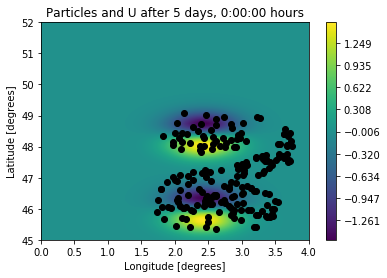

In [9]:
pset.show(field=fieldset.U)

## Wrap whole experiment in a function

As a first step towards parallelization, we wrap the whole experiment in a function with only the essiential args.

Note that there's a `prefix` that will later be used to name the output files in parallel runs.

In [10]:
def run_eddy_exp(lons, lats, prefix):
    fieldset = FieldSet.from_parcels("input_data/moving_eddies")
    
    pset = ParticleSet.from_list(fieldset=fieldset,
                                 pclass=JITParticle,
                                 lon=lons, lat=lats)
    
    pset.execute(AdvectionRK4,
                 runtime=timedelta(days=5),
                 dt=timedelta(minutes=5),
                 output_file=pset.ParticleFile(
                     name="output_data/{}EddyParticles.nc".format(prefix),
                     outputdt=timedelta(hours=1)))

## Rerun wrapped experiment

Execution times should be identical.

In [11]:
%%time
run_eddy_exp(lons, lats, "wrapped_")

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/700d5f9d1e97bc515c7ade59346437d9.so


CPU times: user 20.2 s, sys: 888 ms, total: 21.1 s
Wall time: 22.9 s


## First step towards distribution: Split into independent tasks

Map the experiment to only subsets of the initial positions.

In [12]:
%%time
experiments = map(run_eddy_exp,
                  np.split(lons, 4),
                  np.split(lats, 4),
                  ("serial_{:04d}_".format(n) for n in range(4)))
e = list(experiments);

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/da4a4918c7530b27a17ffb6a169286a1.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/d44cb955f31e54cda588b0b027e4dac2.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/b00d6868ff635fe23ab7b452459e3d31.so
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/7f313107fdf4378015581a7cde4c65cd.so


CPU times: user 21.2 s, sys: 3.69 s, total: 24.8 s
Wall time: 30 s


## Distribute with dask

We spin up a (local) cluster with `dask.distributed` and use `dask.bag` to map the experiment to a sequence of parameters living on this cluster.

In [13]:
from dask.distributed import Client

In [14]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit=2e9)
client

Client Scheduler: tcp://127.0.0.1:42072 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [15]:
import dask.bag as db

In [16]:
%%time
experiments = db.from_sequence(
    zip(np.split(lons, 4),
        np.split(lats, 4),
        ("dask_{:04d}_".format(n) for n in range(4)))
).map(lambda p: run_eddy_exp(*p))
e = experiments.compute();

CPU times: user 1.62 s, sys: 88 ms, total: 1.7 s
Wall time: 10.3 s


On two double-threaded CPUs, this only took about 30% of the time it took for serial execution of the sub-experiments.

## Check output

In [17]:
!ls -1 output_data/*.nc

output_data/dask_0000_EddyParticles.nc
output_data/dask_0001_EddyParticles.nc
output_data/dask_0002_EddyParticles.nc
output_data/dask_0003_EddyParticles.nc
output_data/EddyParticles.nc
output_data/serial_0000_EddyParticles.nc
output_data/serial_0001_EddyParticles.nc
output_data/serial_0002_EddyParticles.nc
output_data/serial_0003_EddyParticles.nc
output_data/wrapped_EddyParticles.nc
